<a href="https://colab.research.google.com/github/JJungEEun/lotte_project/blob/lattehauma-patch-1-1/%EC%B5%9C%EC%A2%85%EC%A0%9C%EC%B6%9C%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 제목제목제목

## 2. 데이터 전처리

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
demo = pd.read_csv("/content/drive/MyDrive/colab/lotte/LPOINT_BIG_COMP_01_DEMO.csv") #고객 데모 정보
pdde = pd.read_csv("/content/drive/MyDrive/colab/lotte/LPOINT_BIG_COMP_02_PDDE.csv") #상품 구매 정보(유통사 상품 구매 내역)
pd_clac = pd.read_csv("/content/drive/MyDrive/colab/lotte/LPOINT_BIG_COMP_04_PD_CLAC.csv") #상품 분류 정보(유통사 상품 카테고리 마스터)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
#데이터 결합
df = pd.merge(pdde, pd_clac,how='outer',on='pd_c')
df = pd.merge(df, demo, how='left', on='cust')
print(df.shape)
df.head()

(4381743, 16)


,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,pd_nm,clac_hlv_nm,clac_mcls_nm,ma_fem_dv,ages,zon_hlv
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.0,1,남성티셔츠,남성의류,남성의류상의,여성,50대,Z17
1,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1,남성티셔츠,남성의류,남성의류상의,여성,50대,Z17
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1,남성티셔츠,남성의류,남성의류상의,여성,50대,Z17
3,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.0,1,남성티셔츠,남성의류,남성의류상의,여성,50대,Z17
4,M506355556,A01000107137,1,A01,A010032,PD0290,20210101,15,199000.0,1,남성티셔츠,남성의류,남성의류상의,여성,40대,Z17


이상치 제거

In [4]:
df=df[df['cust']!='M057015266']
df=df[df['cust']!='M919374790']
print(df.shape)

(4359246, 16)


결측치 확인

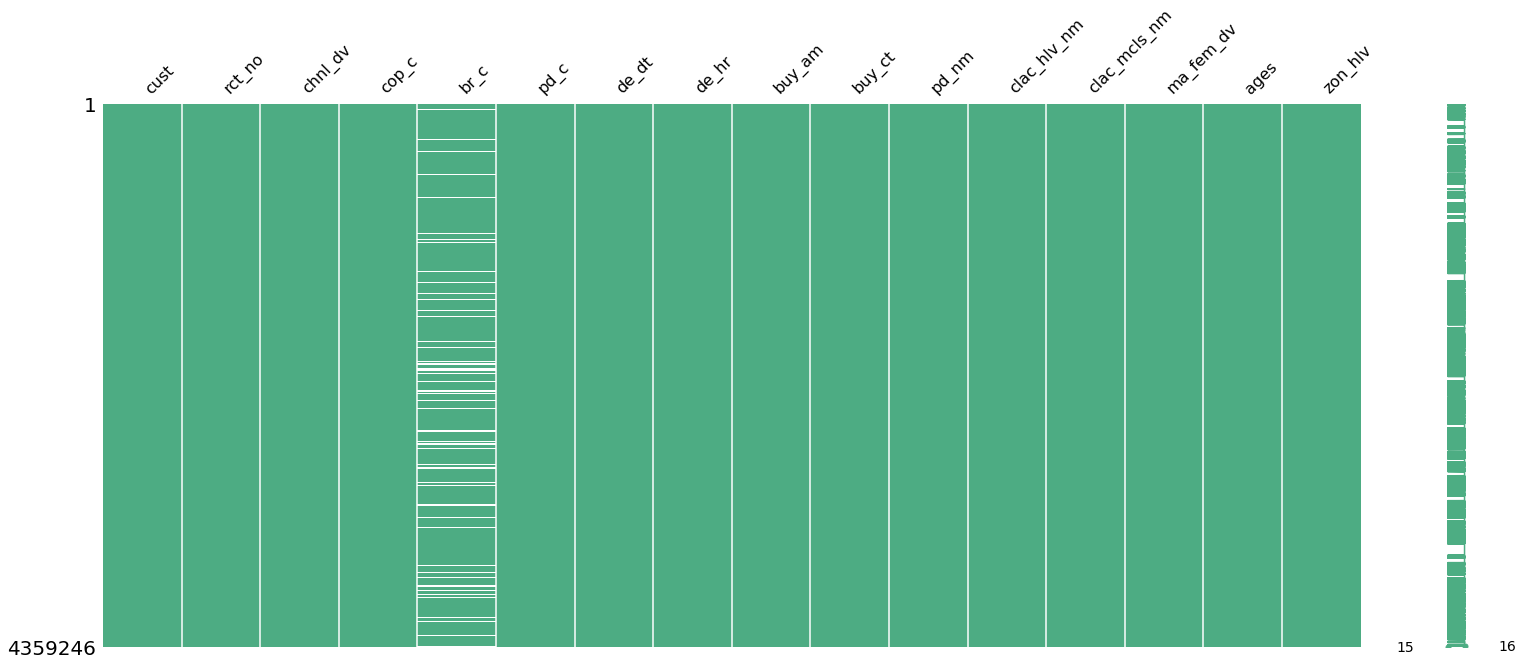

In [5]:
import missingno as msno
msno.matrix(df, color = (0.302, 0.678, 0.514))

변수 정리

In [6]:
#날짜변수
from datetime import datetime

a = df['de_dt'].astype('str')
df['de_dt']  = pd.to_datetime(a)
df['day'] = df['de_dt'].map(lambda x : x.strftime('%A'))
df['month'] = df['de_dt'].dt.month #월변수 생성
df['day'] = df['de_dt'].dt.day #일변수 생성

In [7]:
#계절변수
def wea_fun(x):
  y=''
  if x==3 or x==4 or x==5: y='spr'
  elif x==6 or x==7 or x==8: y='smn'
  elif x==9 or x==10 or x==11: y='atm'
  else: y='win'
  return y

#함수 적용
df["weat"] = df["month"].apply(lambda x: wea_fun(x))

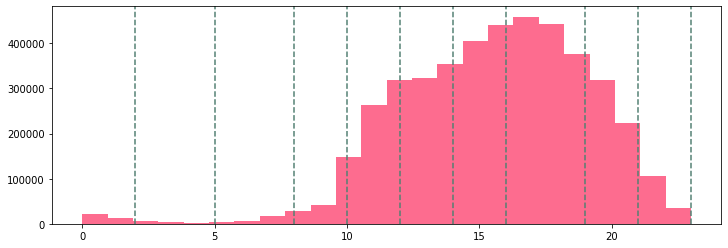

In [8]:
#구매 시간 변수
plt.figure(figsize=(12,4))

plt.hist(df['de_hr'],bins=24, color='#FD6C8F')
b = [2,5,8,10,12,14,16,19,21,23]
for i in b:
  plt.axvline(i,0,1,color="#528073",linestyle='--')

In [9]:
def time_fun(x):
  y=''
  if x>=2 and x<5: y='a_1'
  elif (x>=5 and x<8): y='a_2'
  elif (x>=8 and x<10): y='a_3'
  elif (x>=10 and x<12): y='a_4'
  elif (x>=12 and x<14): y='a_5'
  elif (x>=14 and x<16): y='a_6'
  elif (x>=16 and x<19): y='a_7'
  elif (x>=19 and x<21): y='a_8'
  elif (x>=21 and x<23): y='a_9'
  else: y='a_10'
  return y

#함수 적용
df["de_hr_1"] = df["de_hr"].apply(lambda x: time_fun(x))

In [10]:
#구매 분산 변수
dftime=df.groupby('cust')['de_hr'].var()
dftime=pd.DataFrame(dftime)
dftime.columns=['hrvar']
df=pd.merge(df,dftime, on='cust', how='left')

In [11]:
#성별 인코딩: 여1, 남0을 사용합니다
df['ma_fem_dv']=df.ma_fem_dv.apply(lambda x: 1 if x=='여성' else 0)

In [12]:
#연령: 연령대의 대표값으로 나타내기 위해, 연령대+ 5를 사용합니다
df['ages']=df.ages.apply(lambda x: int(x[:-1])+5)

In [13]:
#요일 변수
datedict={0:'mon',1:'tue',2:'wed',3:'thu',4:'fri',5:'sat',6:'sun'}
df["weekday"] = df["de_dt"].apply(lambda x: datedict[x.weekday()])
df['weekday']=df.weekday.apply(lambda x: 1 if x=='sat' or x=='sun' else 0)

In [14]:
#주말이 아닌 공휴일 변수
#혜린이 코드에서 조금 변경사항 있어욥 
holi=[]
holiday=['0101','0211','0212','0301','0505','0519','0816','0920','0921','0922','1004','1011']
for h in holiday:
  holi.append('2021'+h)

c = pd.to_datetime(holi)
df['holi']=df.de_dt.apply(lambda x: 1 if x in c else 0)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


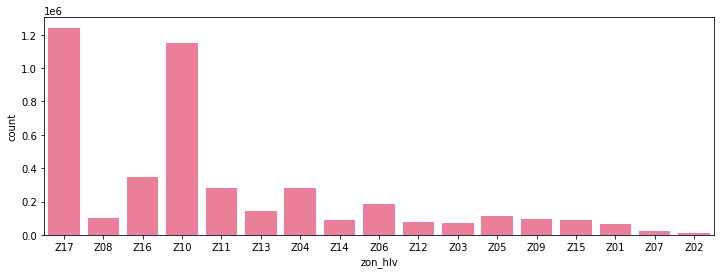

In [15]:
#거주 지역 시각화
plt.figure(figsize=(12,4))

sns.countplot(df['zon_hlv'],color='#FD6C8F')

In [16]:
#거주지역 변수 설정
df['zon_hlv']=df.zon_hlv.apply(lambda x: 1 if x=='Z17' or x=='Z10' else 0)

날씨 변수 추가

In [17]:
#날씨 데이터
temp=pd.read_csv('/content/drive/MyDrive/colab/lotte/df24_temprain.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [18]:
#########임시!!!!!!!!
temp=temp.groupby('de_dt')[['rain','temp']].min()

In [19]:
temp=temp.reset_index()

In [20]:
#강수량 데이터 가공
d = temp['rain'][1]
def num_fun(xx):
  return float(xx[:-2])
temp["rain"] = temp["rain"].apply(lambda x: 0 if x==d else num_fun(x))
#날짜 형태 변환
e = temp['de_dt'].astype('str')
temp['de_dt']  = pd.to_datetime(e)

In [21]:
df = pd.merge(df, temp,how='left',on='de_dt')

제휴사 관련 데이터 추가

In [22]:
def A1(x): #쇼핑몰, 백화점
  if x=='A01' or x=='A06':
    return 1
  else:
    return 0

def A2(x): #식료품점, 대형마트
  if x=='A02' or x=='A03':
    return 1
  else:
    return 0

def A3(x): #편의점
  if x=='A04':
    return 1
  else:
    return 0

def A4(x): #가전제품 매장
  if x=='A05':
    return 1
  else:
    return 0

In [23]:
#원핫인코딩 방식으로 개별 열로 저장한다 
df['A1']=df.cop_c.apply(A1)
df['A2']=df.cop_c.apply(A2)
df['A3']=df.cop_c.apply(A3)
df['A4']=df.cop_c.apply(A4)

In [ ]:
usedf=df[['de_hr_1','buy_am','buy_ct','ma_fem_dv','ages','weat','zon_hlv','ㅐone_times_items',
          'rebuy_ration',]]
usedf.to_csv('/content/drive/MyDrive/colab/lotte/final_df.csv') #csv파일로 생성

In [24]:
print(df.shape)
df.head()

(4359246, 29)


,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,...,de_hr_1,hrvar,weekday,holi,rain,temp,A1,A2,A3,A4
0,M430112881,A01000001113,1,A01,A010039,PD0290,2021-01-01,10,15000.0,1,...,a_4,9.266085,0,1,0.0,-4.2,1,0,0,0
1,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,...,a_4,9.266085,0,1,0.0,-4.2,1,0,0,0
2,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,...,a_4,9.266085,0,1,0.0,-4.2,1,0,0,0
3,M430112881,A01000004946,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,...,a_4,9.266085,0,1,0.0,-4.2,1,0,0,0
4,M506355556,A01000107137,1,A01,A010032,PD0290,2021-01-01,15,199000.0,1,...,a_6,4.290058,0,1,0.0,-4.2,1,0,0,0


______________

## 3. 탐색적 데이터 분석(EDA)

### 필요한 변수 추가

1. 고객 구매 수량 관련 변수 분석

In [24]:
#고객의 총 주문한 상품 수
order1 = df.groupby('cust').sum()['buy_ct'].rename_axis('cust').reset_index(name='total_items')
#한번에 주문한 상품의 수
order2 = df[['rct_no']].value_counts().reset_index(name='one_times_items') 
#구매 횟수
order3 = df.groupby('cust')['rct_no'].nunique().reset_index(name='rct_cnt')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(0.0, 3500.0)

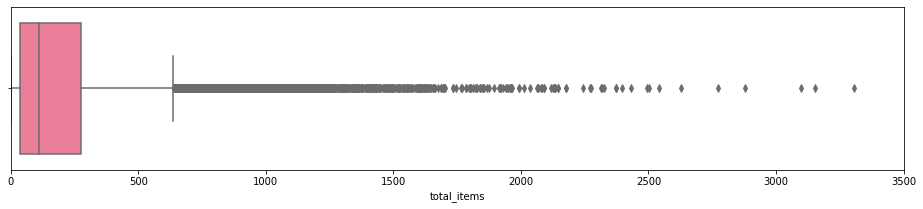

In [23]:
plt.figure(figsize=(16,3))
pp=sns.boxplot(order1['total_items'], color='#FD6C8F')
plt.xlim(0, 3500)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(0.0, 600.0)

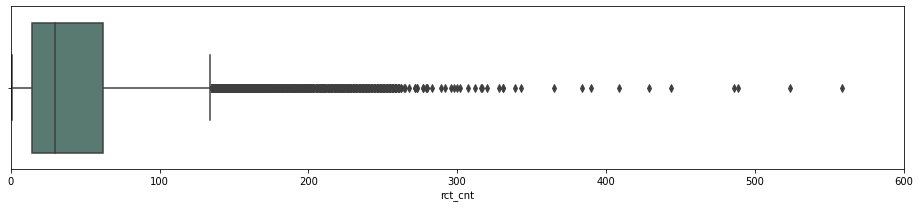

In [27]:
plt.figure(figsize=(16,3))

sns.boxplot(order3['rct_cnt'], color='#528073')
plt.xlim(0, 600)

In [25]:
df = pd.merge(df, order1, how='outer',on='cust')
df = pd.merge(df, order2, how='outer',on='rct_no')
df = pd.merge(df, order3, how='outer',on='cust')

2. 재구매 여부 변수 추가

In [34]:
#재재구구매  1차 
rebuy_df = df.groupby(['cust', 'clac_mcls_nm','de_dt']).sum()['buy_ct'].reset_index(name='buy_cnt') 
rebuy_df=rebuy_df.sort_values(['cust','clac_mcls_nm','de_dt'])

rebuy_df['dt_diff']=rebuy_df['de_dt'].diff()
rebuy_df.loc[rebuy_df['cust'] != rebuy_df['cust'].shift(), 'dt_diff']=None
rebuy_df.loc[rebuy_df['clac_mcls_nm'] != rebuy_df['clac_mcls_nm'].shift(), 'dt_diff']= None

rebuy_df['dt_diff']=rebuy_df['dt_diff'].dt.days
rebuy_df['dt_diff']=rebuy_df['dt_diff'].fillna(365)

rebuy_df['rebuy']=0
rebuy_df.loc[rebuy_df['dt_diff']<=31, 'rebuy']=1

In [35]:
rebuy_df=rebuy_df[['cust','clac_mcls_nm','rebuy']]

In [36]:
rebuy_df.shape

(3287899, 3)

In [ ]:
df = pd.merge(df, rebuy_df, how='outer',on=['cust','clac_mcls_nm'])

In [28]:
df.shape

(4359246, 33)

In [29]:
df.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,...,rain,temp,A1,A2,A3,A4,total_items,one_times_items,rct_cnt,rebuy
0,M430112881,A01000001113,1,A01,A010039,PD0290,2021-01-01,10,15000.0,1,...,0.0,-4.2,1,0,0,0,580,1,102,1
1,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,...,0.0,-4.2,1,0,0,0,580,2,102,1
2,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,...,0.0,-4.2,1,0,0,0,580,2,102,1
3,M430112881,A01000004946,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,...,0.0,-4.2,1,0,0,0,580,1,102,1
4,M430112881,A01000013098,1,A01,A010039,PD0292,2021-01-01,11,19900.0,1,...,0.0,-4.2,1,0,0,0,580,1,102,1


3. 총 재구매 횟수 변수 추가

In [ ]:
rebuy_df = df.groupby(['cust', 'clac_mcls_nm']).sum()['buy_ct'].reset_index(name='rebuy_cnt') 
rebuy_df['rebuy_cnt'] -= 1
rebuy_df = rebuy_df.groupby('cust').sum()['rebuy_cnt'].reset_index(name='rebuy_cnt') 

df = pd.merge(df, rebuy_df, how='outer',on='cust')
df.head()

4. 재구매 비율 변수 추가

In [27]:
df['rebuy_ration'] = df['rebuy_cnt']/df['total_items']*100

KeyError: ignored

5. 재구매까지 걸린 기간 변수 추가

In [ ]:
df = df.sort_values(['cust','de_dt'])
df['de_diff'] = df['de_dt'].diff()
df.loc[df['cust'] != df['cust'].shift(),'de_diff'] = None

df['de_diff'] = df['de_diff'].dt.days

In [ ]:
msno.matrix(df[['total_items', 'one_times_items', 'rct_cnt',
       'rebuy', 'rebuy_cnt', 'rebuy_ration', 'de_diff']], color = (0.302, 0.678, 0.514))

In [ ]:
df = df.fillna(365)

### 변수 개별 분석

In [ ]:
sns.histplot(df, x="chnl_dv", hue="rebuy", stat="probability", multiple="fill",shrink=-10)

In [ ]:
sns.histplot(df, x="de_hr_1", hue="rebuy", stat="probability", multiple="fill",shrink=0.8)

In [30]:
df.to_csv('/content/drive/MyDrive/colab/lotte/final_df.csv') #csv파일로 생성
rebuy_df.to_csv('/content/drive/MyDrive/colab/lotte/rebuy_df.csv')

In [ ]:
#df.columns